In [15]:

import torch
import numpy as np
import matplotlib.pyplot as plt

#from lab 6:
from helper import generate_dataset, visualize_one_dataset, visualize_datasets, predict_grid, visualize_predictions
from torch.utils import data

In [16]:


def scaling_selection(g, H, sigma, constant_learning_rate=True):

    Hg = torch.matmul(H, g)
    dot_product = torch.dot(g, Hg)
    norm_g = torch.norm(g)

    if constant_learning_rate:
        s_lpc_min = 1 / sigma
        s_lpc_max = 1 / sigma
    else:
        s_lpc_min = (1 / sigma) * torch.rand(1).item()
        s_lpc_max = 1 / sigma

    s_CG = norm_g**2 / dot_product
    s_MR = dot_product / torch.norm(Hg)**2
    s_GM = torch.sqrt(s_CG * s_MR)

    if dot_product > sigma * norm_g**2:
        spc = torch.tensor([s_CG, s_MR, s_GM])[torch.randint(0, 3, (1,)).item()]
        return -spc * g, "SPC"
    elif dot_product > 0 and dot_product < sigma * norm_g**2:
        slpc = torch.empty(1).uniform_(s_lpc_min, 1 / sigma).item()
        return -slpc * g, "LPC"
    else:
        snc = torch.empty(1).uniform_(s_lpc_min, s_lpc_max).item()
        return -snc * g, "NC"


In [17]:
#algorithm 3 backward tracking line search

def backtracking_LS(model, theta, rho, x, g, p):

    alpha = 1.0
    while model(x + alpha * p) > model(x) + alpha * rho * torch.dot(g, p):
        alpha *= theta


    return alpha


In [18]:
# algorithm 4 forward/backward tracking line search

def forward_backward_LS(model, theta, rho, x, g, p):


    alpha = 1.0
    if model(x + alpha * p) > model(x) + alpha * rho * torch.dot(g, p):
        backtracking_LS(model, theta, rho, x, g, p)
    else:
        while model(x + alpha * p) >= model(x) + alpha * rho * torch.dot(g, p):
            alpha /= theta

    return alpha * theta

    

In [19]:
# algorithm 2: scaled gradient descent with line search

def scaled_GD_norm_squared(model, x0, sigma, rho, theta_bt, theta_fb, MAX_ITER, eps):
    """
    sigma <<< 1
    0 < theta < 1
    0 < rho < 1/2
    """

    x_k = x0.clone()
    flag_distribution = {"SPC": 0, "LPC": 0, "NC": 0}

    for _ in range(MAX_ITER):
        g_k = 2 * x_k

        if torch.norm(g_k) < eps:
            break

        # Use identity matrix as Hessian approximation
        H_k = torch.eye(len(x_k), dtype=x_k.dtype, device=x_k.device)
        p_k, FLAG = scaling_selection(g_k, H_k, sigma)
        flag_distribution[FLAG] += 1

        if FLAG in ["SPC", "LPC"]:
            alpha_k = backtracking_LS(model, theta_bt, rho, x_k, g_k, p_k)
        else:
            alpha_k = forward_backward_LS(model, theta_fb, rho, x_k, g_k, p_k)

        x_k = x_k + alpha_k * p_k

    return x_k, flag_distribution


In [20]:
class NormSquaredModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.norm(x)**2

In [21]:
#try with ||x||² for now
model = NormSquaredModel()

sigma = 0.1
theta_bt = 0.5
theta_fb = 0.5
rho = 0.25

MAX_ITER = 1000
eps = 1e-12

x_0 = 10 * torch.randn(10)



x_star, flag_distribution = scaled_GD_norm_squared(model, x_0, sigma, rho, theta_bt, theta_fb, MAX_ITER, eps)

x_star, flag_distribution

(tensor([-5.4210e-20, -6.7763e-21, -6.7763e-21, -1.3553e-20, -1.3553e-20,
          6.7763e-21, -1.3553e-20,  1.3553e-20, -2.1176e-22, -6.7763e-21]),
 {'SPC': 3, 'LPC': 0, 'NC': 0})

In [22]:
# must define a classification/regression task and make scaled_gd overwrite torch.optim.Optimizer
# https://www.geeksforgeeks.org/custom-optimizers-in-pytorch/

class SimpleMLP(torch.nn.Sequential):
    def __init__(self, hidden_dim):
        self.name = 'NN'
        self.num_classes = 2
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: Define your neural network model with ReLU
        # HINT: Use torch.nn.Sequential and torch.nn.ReLU
        # ***************************************************
        super().__init__(
            torch.nn.Linear(2, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, self.num_classes),
        )
        
    def init_params(self, train_data):
        ''' No need to do anything since it is taken care of by torch.nn.Sequential'''

In [58]:
class Scaled_GD_Optimizer(torch.optim.Optimizer):
    def __init__(self, params, sigma, rho, theta_bt, theta_fb):
        defaults = dict(sigma=sigma, rho=rho, theta_bt=theta_bt, theta_fb=theta_fb, eps=eps)
        super().__init__(params, defaults)

    def step(self, closure):
        loss = closure()

        with torch.no_grad():
            for group in self.param_groups:
                sigma = group["sigma"]
                rho = group["rho"]
                theta_bt = group["theta_bt"]
                theta_fb = group["theta_fb"]

                for p in group['params']:
                    if p.grad is None:
                        continue

                    x_k = p.data.data.flatten().clone()
                    g_k = p.grad.data.flatten().clone()

                    g_k.require_grad = True
                    x_k.require_grad = True


                    H_k = torch.eye(len(x_k))

                    p_k, FLAG = scaling_selection(g_k, H_k, sigma)

                    if FLAG in ["SPC", "LPC"]:
                        alpha_k = backtracking_LS(closure(), theta_bt, rho, x_k, g_k, p_k)
                    else:
                        alpha_k = forward_backward_LS(closure(), theta_fb, rho, x_k, g_k, p_k)
            
                    x_k = x_k + alpha_k * p_k
                    p.data.copy_(x_k)


        return loss


In [59]:
"""
        with torch.no_grad():
            for group in self.param_groups:
                sigma = group["sigma"]
                rho = group["rho"]
                theta_bt = group["theta_bt"]
                theta_fb = group["theta_fb"]

                for p in group['params']:
                    if p.grad is None:
                        continue

                    x_k = p.data.clone()
                    g_k = p.grad.data.clone()

                    H_k = None

                    p_k, FLAG = scaling_selection(g_k, H_k, sigma)

                    if FLAG in ["SPC", "LPC"]:
                        alpha_k = backtracking_LS(loss, theta_bt, rho, x_k, g_k, p_k)
                    else:
                        alpha_k = forward_backward_LS(loss, theta_fb, rho, x_k, g_k, p_k)
            
                    x_k = x_k + alpha_k * p_k
                    p.data.copy_(x_k)
"""

'\n        with torch.no_grad():\n            for group in self.param_groups:\n                sigma = group["sigma"]\n                rho = group["rho"]\n                theta_bt = group["theta_bt"]\n                theta_fb = group["theta_fb"]\n\n                for p in group[\'params\']:\n                    if p.grad is None:\n                        continue\n\n                    x_k = p.data.clone()\n                    g_k = p.grad.data.clone()\n\n                    H_k = None\n\n                    p_k, FLAG = scaling_selection(g_k, H_k, sigma)\n\n                    if FLAG in ["SPC", "LPC"]:\n                        alpha_k = backtracking_LS(loss, theta_bt, rho, x_k, g_k, p_k)\n                    else:\n                        alpha_k = forward_backward_LS(loss, theta_fb, rho, x_k, g_k, p_k)\n            \n                    x_k = x_k + alpha_k * p_k\n                    p.data.copy_(x_k)\n'

In [60]:


NUM_SAMPLES = 100

blobs_train, blobs_test = generate_dataset("blobs", NUM_SAMPLES)
moons_train, moons_test = generate_dataset("moons", NUM_SAMPLES)
xor_train, xor_test = generate_dataset("xor", NUM_SAMPLES)
squares_train, squares_test = generate_dataset("bar", NUM_SAMPLES)

In [61]:
train_loader = data.DataLoader(blobs_train, batch_size=10, shuffle=True)
test_loader = data.DataLoader(blobs_test, batch_size=NUM_SAMPLES)

loss_fn = torch.nn.CrossEntropyLoss()
model = SimpleMLP(hidden_dim=256)
optimizer = Scaled_GD_Optimizer(model.parameters(), sigma, rho, theta_bt, theta_fb)


sigma = 1e-2
theta_bt = 0.5
theta_fb = 0.5
rho = 0.25
N_EPOCH = 1000

In [62]:
losses = np.zeros(N_EPOCH)

for epoch in range(N_EPOCH):
    for minibatch, label in train_loader:

        label = label.long()

        def closure():
            optimizer.zero_grad()
            prediction = model(minibatch)
            loss = loss_fn(prediction, label)
            loss.backward()
            return loss

        loss = optimizer.step(closure)

    # Compute the test loss
    for minibatch, label in test_loader:
        label = label.long()
        with torch.no_grad():
            loss = loss_fn(model(minibatch), label)
            losses[epoch] = loss.item()

            if epoch % 100 == 0:
                print(epoch, loss.item())


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

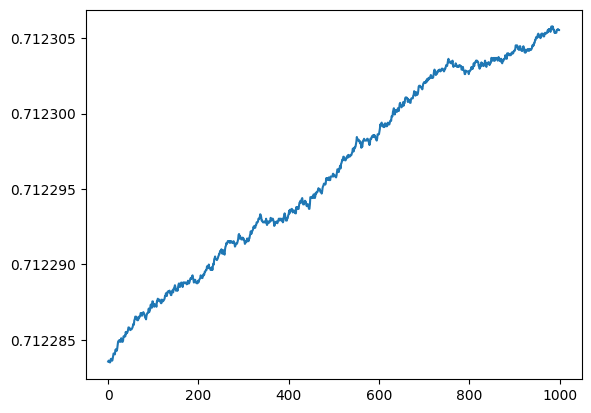

In [ ]:
plt.plot(range(N_EPOCH), losses)